In [801]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
from qutip import *
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from IPython.display import Image
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG
import tqdm
from numpy import random
from scipy.optimize import curve_fit
from matplotlib.cm import ScalarMappable

""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
mu_0 = sp.constants.mu_0
hbar = sp.constants.hbar
h = sp.constants.h
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]
inch = 25.4e-3

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [802]:
numm = 6
M = 1.2 #in T (also known as remanance)
V = 10*25*3e-9 #in m3, volume of magnet stack
m = numm*M*V*np.array([[0, 0, 1], [0, 0, -1],[0, 0, 1], [0, 0, -1]])/mu_0 #magnetic moment of the magnet
a = 1.5*inch
ax = 1.5*inch
posm = np.array([[ax, a, 0], [ax, -a, 0], [-ax, a, 0], [-ax, -a, 0]]) #position of the magents

In [803]:
def Bfield(r):
    b = 0
    for i, mi in enumerate(m):
        dist = np.sqrt(np.sum(np.square(r-posm[i])))
        b += mu_0/4/np.pi * (3*(r-posm[i])*np.dot(mi, r-posm[i])/dist**5 - mi/dist**3)
    return b

# Bfield with 4 magnet stacks:

In [804]:
y = np.linspace(-1*inch, 1*inch, 15)
z = np.linspace(-1*inch, 1*inch, 15)

rb = np.array([[np.array([0,yy,zz]) for yy in y] for zz in z])

B = np.array([[Bfield(rb[j][i]) for i in range(len(y))] for j in range(len(z))]).transpose()
Bx = B[:,:][0]
By = B[:,:][1]
Bz = B[:,:][2]
Bmag = np.sqrt(By**2+Bz**2+Bx**2)

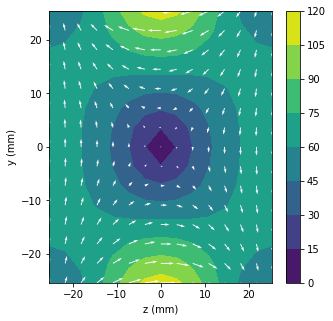

In [805]:
plt.figure(figsize=(5,5))
plot = plt.contourf(z*1e3, y*1e3, Bmag*1e4, extent=[y[0],y[-1],z[0],z[-1]], origin='lower', levels=10)
plt.quiver(z*1e3, y*1e3, Bz, By, color='white')
plt.xlabel('z (mm)')
plt.ylabel('y (mm)')
plt.colorbar(plot)

In [806]:
def line(x, a, b):
    return a*(x)+b

gradient: -43.00080012415731 G/cm


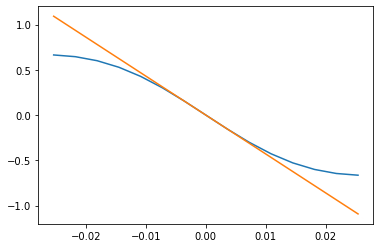

In [807]:
popt, pcov = curve_fit(line, y[6:-6], By[8,:][6:-6]*1e4/1e2)
plt.plot(y, By[8,:]*1e4/1e2)
plt.plot(y, line(y, *popt))
print('gradient:', popt[0], 'G/cm')

In [808]:
y = np.linspace(-0.3*inch, 0.3*inch, 15)
x = np.linspace(-0.3*inch, 0.3*inch, 15)

rb = np.array([[np.array([xx,yy,0]) for yy in y] for xx in x])

B = np.array([[Bfield(rb[j][i]) for i in range(len(y))] for j in range(len(x))]).transpose()
By = B[:,:][1]
Bx = B[:,:][0]
Bz = B[:,:][2]
Bmag = np.sqrt(By**2+Bx**2+Bz**2)

C:\Users\klab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\quiver.py:689: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\klab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


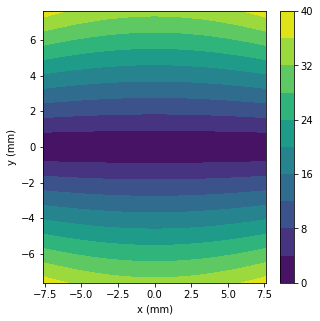

In [809]:
plt.figure(figsize=(5,5))
plot=plt.contourf(x*1e3, y*1e3, Bmag*1e4, extent=[y[0],y[-1],x[0],x[-1]], origin='lower', levels=10)
plt.quiver(x*1e3, y*1e3, Bx, By, color='white')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.colorbar(plot)

# Monte Carlo

https://arxiv.org/abs/physics/0103085v1

In [810]:
tot_count = 500
dt = 50e-3/tot_count

In [811]:
_lambda = 399e-9
k = 2*np.pi/_lambda
Isat = 60e-3*1e4 #W/m2
Gamma = 30e6
w = 15e-3
P = 150e-3
I0 = 2*P/np.pi/w**2
m171 = 171*u
Delta = -2*Gamma

In [812]:
def pi_pol(B):
    Bnorm = B/np.linalg.norm(B)
    return Bnorm

def sigm_pol(B):
    Bnorm = B/np.linalg.norm(B)
    ihat = x
    jhat = Bnorm
    khat = np.cross(ihat, jhat)
    return -1/np.sqrt(2)*(khat+1j*ihat)

def sigp_pol(B):
    Bnorm = B/np.linalg.norm(B)
    ihat = x
    jhat = Bnorm
    khat = np.cross(ihat, jhat)
    return 1/np.sqrt(2)*(khat-1j*ihat)

def LH_pol(k):
    knorm = k/np.linalg.norm(k)
    ihat = x
    jhat = knorm
    khat = np.cross(ihat, jhat)
    return 1/np.sqrt(2)*(z+1j*ihat)

def RH_pol(k):
    knorm = k/np.linalg.norm(k)
    ihat = x
    jhat = knorm
    khat = np.cross(ihat, jhat)
    return 1/np.sqrt(2)*(z-1j*ihat)
    

In [813]:
def force2Dmot(r,v):
    
    s = []
    
    for i in range(len(ki)):
        
        si = 0
                
        for dmj in [-1, 0, 1]:
            B = Bfield(r)

            if dmj == -1:
                transition = sigm_pol(B)
            elif dmj == 0:
                transition = pi_pol(B)
            elif dmj == 1:
                transition = sigp_pol(B)
            
            overlap = np.dot(poli[i], transition)
            dist = np.sqrt(np.sum( np.abs(np.cross(r, ki[i]/k))**2))
            Ii = I0*np.exp( -2*dist**2/w**2 )
            deltai = Delta - np.dot(ki[i], v) + dmj*mB/hbar*np.sqrt(np.sum(np.square(B)))
            sim = overlap**2 * Ii/Isat * Gamma**2 / (Gamma**2 + 4*deltai**2)

            si = si+sim
            
        s.append(si)
    
    s = np.array(s)
    
    fi = [hbar*ki[i]*Gamma/2*s[i]/(1+np.sum(s)) for i in range(len(ki))] 

    return np.sum(fi, axis=0)

In [864]:
def RK4(xn, vn):
    
    h = dt

    k1x = vn
    k1v = force2Dmot(xn, vn)/m171
    
    k2x = vn + k1v*h/2
    k2v = force2Dmot(xn + k1x*h/2, vn + k1v*h/2)/m171
    
    k3x = vn + k2v*h/2
    k3v = force2Dmot(xn + k2x*h/2, vn + k2v*h/2)/m171
    
    k4x = vn + k3v*h
    k4v = force2Dmot(xn + k3x*h, vn + k3v*h)/m171
    
    vn1 = vn + (k1v + 2*k2v + 2*k3v + k4v)*(h/6)
    xn1 = xn + (k1x + 2*k2x + 2*k3x + k4x)*(h/6)

    return xn1, vn1, force2Dmot(xn, vn)/m171

In [865]:
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

ki = k*np.array( [ -y+z, -y-z, y+z, y-z]) #, -y+z, -y-z wavevectors of the mot beams
poli = np.array( [ LH_pol(ki[0]), RH_pol(ki[1]), RH_pol(ki[2]), LH_pol(ki[3])]) #

In [871]:
r0 = np.array([0.,-15e-3, 0.])
v0 = np.array([0., 10, 0])

pos_array = []
vel_array = []
f_array = []
count_array = []

r = r0
v = v0

count = 0
while count<tot_count:
    r, v, f = RK4(r, v)
    pos_array.append(r)
    vel_array.append(v)
    count_array.append(count)
    f_array.append(f)
    count = count+1
    
pos_array = np.real(np.array(pos_array) )
vel_array = np.real(np.array(vel_array) )
count_array = np.array(count_array)
f_array = np.array(f_array)

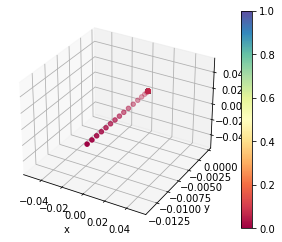

In [872]:
ax = plt.figure().add_subplot(projection='3d')

# Prepare arrays x, y, z
zplot = pos_array[:,2]
xplot = pos_array[:,0]
yplot = pos_array[:,1]

cmap = plt.get_cmap("Spectral")
sm =  ScalarMappable(cmap=cmap)
sm.set_array([])
ax.scatter(xplot, yplot, zplot, c=cmap(count_array))

plt.xlabel('x')
plt.ylabel('y')

cbar = plt.colorbar(sm, ax=ax)
plt.show()


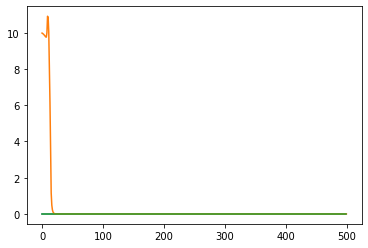

In [873]:
plt.plot(vel_array)

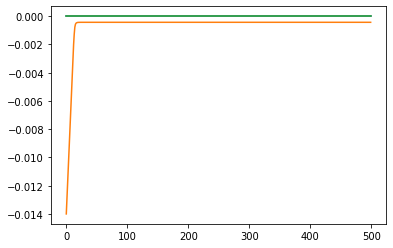

In [874]:
plt.plot(pos_array)

C:\Users\klab\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


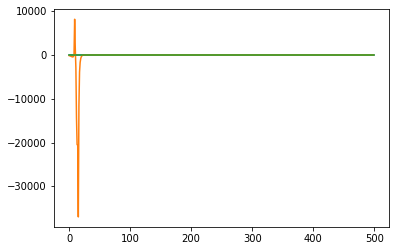

In [875]:
plt.plot(f_array)